In [1]:
# For reloading
import importlib

# My modules
import datasets
import utils
import models
import train
import config as cfg

import time
# ALL the imports, should not need all
import tensorflow as tf
# from tensorflow.keras.layers import Conv2D
import numpy as np

# Video and visualization stuff
import tqdm
import PIL.Image, PIL.ImageDraw
# Might not need Ipython 
from IPython.display import Image, HTML, clear_output
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import matplotlib.pyplot as plt
from visdom import Visdom

In [8]:
# Only run if you changed something in other files
importlib.reload(utils)
importlib.reload(models)

<module 'models' from '/home/maxi/Documents/UNI/Thesis/dev/SoS/models.py'>

In [ ]:
# TODO check what to do whit that:
print("Check")
# TODO include?
# This shows all 10 numbers next to each other, I think just
# to see what they look like


# X legend but flipped and colors are different, kinda weird but usable
print("Storing x_legend for use in the demo.")
# plt.imshow(x_legend.reshape((-1, 28)))
# plt.show()

# TODO ?
# import json
# samples_str = json.dumps(x_legend.tolist())

# @title visualize CE runs
# eval_bs= 10
# num_steps = 500
# single_run(ca, num_steps, "single_run")
# TODO single run not finished in train file, could be in model or utils

# global plotter
# plotter = VisdomLinePlotter(env_name='Testing Plots')


# Not sure about ca here
# ca = get_model(add_noise=False, loss_type='ce')

# 

# Visdom not so good in Jupyter
# viz = Visdom()
# viz.video(videofile="single_run.mp4")
# exit()

# Model saved as ce_runs.mp4
# TODO open it via web brouser thingy, there is a package for that 
# mvp.ipython_display('single_run.mp4')

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.get_MNIST()
ca = models.CAModel()
trainer = train.Trainer(x_train, y_train, ca)

# Maybe in a different cell if I want to keep training without resetting the log
loss_log = []

Loading MNIST ... Finished after: 4.2507


batch (before/after):


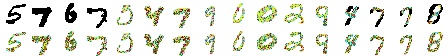

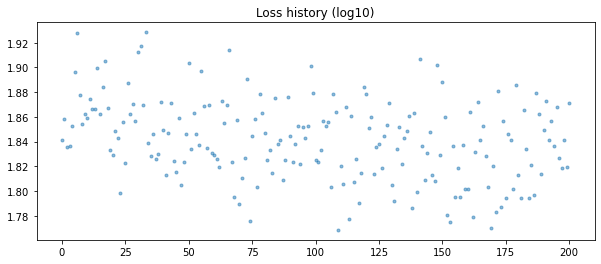

 step: 250, log10(loss): 1.795
 Finished Training in  18.21257209777832


In [4]:
# Each step is one time updating -> ca_num_steps each step
NUM_TRAINING_STEPS = 250
start_time = time.time()
for i in range(1, NUM_TRAINING_STEPS+1):

  # Get current x0, y0 dependent on the model configs
  x0, y0 = trainer.get_new_x_y()

  # Runs ca for ca_num_steps and applies gradients, returns new x
  x, loss = trainer.train_step(x0, y0)

  # Not nice, applying updates to the pool if some model config
  trainer.post_train_step(x, y0)

  # Vis updates:
  step_i = len(loss_log)
  loss_log.append(loss.numpy())

  if step_i%100 == 0:
  	# Looking at the current pool, only makes sense with USE_PATTERN_POOL
    utils.generate_pool_figures(trainer.ca, trainer.pool, step_i)
  if step_i%200 == 0:
  	# From IPython
    clear_output()
    utils.visualize_batch(trainer.ca, x0, x, step_i)
    utils.plot_loss(loss_log)
  if step_i%10000 == 0:
  	# TODO include model name?
    trainer.ca.export_model("models/%07d"%step_i)
    pass

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

print("\n Finished Training in ", time.time() - start_time)

In [5]:
def eval_all(ca, num_steps, mutate):
  all_accuracies = []
  all_agreements = []

  # total test set is 10000
  num_batches = 10
  eval_bs = 10000 // num_batches
  for i in tqdm.trange(num_batches):
    x_set = x_test[eval_bs*i:eval_bs*(i+1)]
    y_set = y_test[eval_bs*i:eval_bs*(i+1)]
    acc_i, agr_i = models.eval_batch_fn(ca, x_set, y_set, num_steps, mutate)
    all_accuracies.append(acc_i)
    all_agreements.append(agr_i)

  all_accuracies = [sum(l)/num_batches for l in zip(*all_accuracies)]
  all_agreements = [sum(l)/num_batches for l in zip(*all_agreements)]
  return all_accuracies, all_agreements


100%|██████████| 10/10 [04:14<00:00, 25.46s/it]

All Acc time:  254.5794723033905


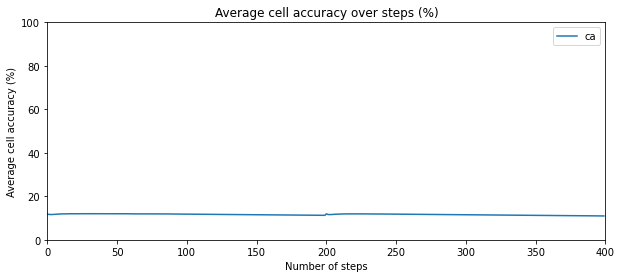

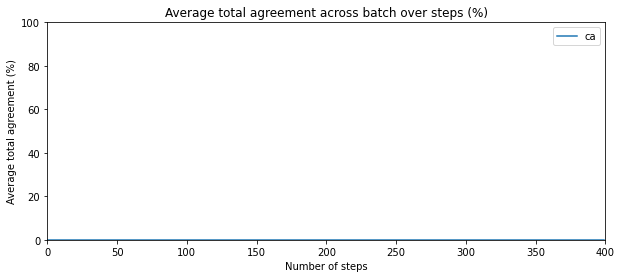

In [6]:
eval_batch = 1000
num_iters = 10

# TODO this takes ages!
start_time = time.time()
all_accuracies, all_agreements = eval_all(trainer.ca, num_steps=200, mutate=True)
print("All Acc time: ", time.time() - start_time)

plt.figure(figsize=(10, 4))
plt.title('Average cell accuracy over steps (%)')
plt.xlabel('Number of steps')
plt.ylabel('Average cell accuracy (%)')
plt.xlim(0, 400)
plt.ylim(0, 100)
plt.plot(all_accuracies, label="ca")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Average total agreement across batch over steps (%)')
plt.xlabel('Number of steps')
plt.ylabel('Average total agreement (%)')
plt.xlim(0, 400)
plt.ylim(0, 100)
plt.plot(all_agreements, label="ca")
plt.legend()

In [9]:
# Careful when running this as js can destroy the whole jupyter Notebook!

#@title TensorFlow.js Demo Full whiteboard {run:"auto", vertical-output: true}
#@markdown Select "CHECKPOINT" model to load the checkpoint created by running 
#@markdown cells from the "Training" section of this notebook.
#@markdown Technical note: CE models should be rendered differently to avoid
#@markdown black pixels showing for low magnitude.
import IPython.display
import glob
import tensorflow as tf

# TODO this loading could be in utils:
samples_str = datasets.get_samples_str(x_train, y_train)

#@markdown draw with left click, hold shift for erasing

# Load model from ckpt:
# glob and stuff to load last json file (highest num_steps, only works with single model name here)
last_checkpoint_fn = sorted(glob.glob('models/*.json'))[-1]
model_str = open(last_checkpoint_fn).read()


data_js = '''
  window.GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
  window.SAMPLES = %s
'''%(model_str, samples_str)

display(IPython.display.Javascript(data_js))

IPython.display.HTML(utils.js_script_drawing)

<IPython.core.display.Javascript object>

In [ ]:
eval_bs= 100
num_steps = 400 

ca = get_model(add_noise=False, loss_type='ce')
make_run_videos(ca, num_steps, eval_bs, "ce_runs", disable_black=True)
mvp.ipython_display('ce_runs.mp4')